# **Using Pre-trained Models in PyTorch to get Rank-1 and Rank-5 Accuracy**
1. We'll first load the pre-trained ImageNet model VGG16
2. We'll get the top 5 classes from a single image inference
3. Next we'll construct a function to give us the rank-N Accuracy using a few test images

In [1]:
# Load our pre-trained VGG16
import torchvision.models as models

model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 103MB/s]


## **Prepare Transform and use model.eval()**

In [2]:
from torchvision import datasets, transforms, models

data_dir = '/images'

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),])

In [3]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### **Download our ImageNet Class Name and our Test Images**

In [4]:
# Get the imageNet Class label names and test images
!wget https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/imageNetclasses.json
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/imagesDLCV.zip
!unzip imagesDLCV.zip
!rm -rf ./images/class1/.DS_Store

--2023-10-22 03:04:38--  https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/imageNetclasses.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33567 (33K) [text/plain]
Saving to: ‘imageNetclasses.json’

imageNetclasses.jso 100%[===================>]  32.78K  --.-KB/s    in 0.006s  

2023-10-22 03:04:38 (5.29 MB/s) - ‘imageNetclasses.json’ saved [33567/33567]

--2023-10-22 03:04:38--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/imagesDLCV.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.148.66, 52.95.149.22, 52.95.191.62, ...
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.148.66|:44

## **Import our modules**

In [5]:
import torch
import json
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


with open('imageNetclasses.json') as f:
  class_names = json.load(f)

# **Load and run a single image through our pre-trained model**

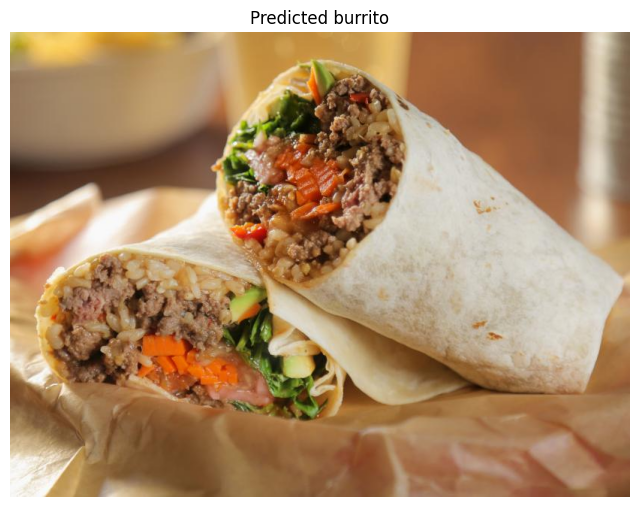

In [6]:
from PIL import Image
import numpy as np

image = Image.open('./images/class1/1539714414867.jpg')

# Convert to Tensor
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
input = Variable(image_tensor)
input = input.to(device)
output = model(input)
index = output.data.cpu().numpy().argmax()
name = class_names[str(index)]

# Plot image
fig=plt.figure(figsize=(8,8))
plt.axis('off')
plt.title(f'Predicted {name}')
plt.imshow(image)
plt.show()

## **Get our Class Probabilities**

In [7]:
import torch.nn.functional as nnf

prob = nnf.softmax(output, dim=1)

top_p, top_class = prob.topk(5, dim = 1)
print(top_p, top_class)

tensor([[0.8664, 0.0189, 0.0170, 0.0164, 0.0069]], device='cuda:0',
       grad_fn=<TopkBackward0>) tensor([[965, 931, 924, 933, 923]], device='cuda:0')


## **Create a class that gives us our class names**

In [8]:
def getClassNames(top_classes):
  top_classes = top_classes.cpu().data.numpy()[0]
  all_classes = []
  for top_class in top_classes:
    all_classes.append(class_names[str(top_class)])
  return all_classes

In [9]:
getClassNames(top_class)

['burrito', 'bagel, beigel', 'guacamole', 'cheeseburger', 'plate']

# **Construct our function to give us our Rank-N Accuracy**

In [18]:
onlyfiles = [f for f in listdir('./images/class1/') if isfile(join('./images/class1/', f))]
onlyfiles

['long-haired-collie-5766447_1280.jpg',
 'limo-safety-ftr.jpg',
 'Basketball_(Ball).jpg',
 '1539714414867.jpg',
 'German_Shepherd_-_DSC_0346_(10096362833).jpg',
 'christmas-stockings-3006869_1280.jpg',
 '81z6x3SZEpL._AC_SL1500_.jpg',
 'spiderweb_1050x700.jpg',
 'download.jpg']

In [14]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(16,16))

def getRankN(model, directory, ground_truth, N, show_images = True):
  # Get image names in directory
  onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]

  # We'll store the top-N class names here
  all_top_classes = []

  # Iterate through our test images
  for (i,image_filename) in enumerate(onlyfiles):
    image = Image.open(directory+image_filename)

    # Convert to Tensor
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    # Get our probabilties and top-N class names
    prob = nnf.softmax(output, dim=1)
    top_p, top_class = prob.topk(N, dim = 1)
    top_class_names = getClassNames(top_class)
    all_top_classes.append(top_class_names)

    if show_images:
      # Plot image
      sub = fig.add_subplot(len(onlyfiles),1, i+1)
      x = " ,".join(top_class_names)
      print(f'Top {N} Predicted Classes {x}')
      plt.axis('off')
      plt.imshow(image)
      plt.show()

  return getScore(all_top_classes, ground_truth, N)

def getScore(all_top_classes, ground_truth, N):
  # Calcuate rank-N score
  in_labels = 0
  for (i,labels) in enumerate(all_top_classes):
    if ground_truth[i] in labels:
      in_labels += 1
  return f'Rank-{N} Accuracy = {in_labels/len(all_top_classes)*100:.2f}%'

<Figure size 1600x1600 with 0 Axes>

In [19]:
# Create our ground truth labels
ground_truth = ['collie',
                'limousine, limo',
                'basketball',
                'burrito',
                'German shepherd, German shepherd dog, German police dog, alsatian',
                'Christmas stocking',
                'doormat, welcome mat',
                "spider web, spider's web",
                'beer_glass',
               ]

## **Get Rank-5 Accuracy**

In [20]:
getRankN(model,'./images/class1/', ground_truth, N=5)

Output hidden; open in https://colab.research.google.com to view.

## **Get Rank-1 Accuracy**

In [21]:
getRankN(model,'./images/class1/', ground_truth, N=1)

Output hidden; open in https://colab.research.google.com to view.

## **Get Rank-10 Accuracy**

In [22]:
getRankN(model,'./images/class1/', ground_truth, N=10)

Output hidden; open in https://colab.research.google.com to view.